In [7]:
# imports
import numpy as np
import qp
import qit
from scipy.optimize import minimize
%matplotlib inline

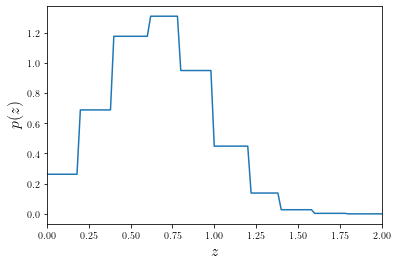

In [8]:
# true distribution of redshifts
Z_TRUE_MIN, Z_TRUE_MAX = 0., 2.
LOC_TRUE = 0.65
SCALE_TRUE = 0.30
N_TRUE_BINS = 10

true_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_TRUE_BINS+1)

true_dist_norm = qp.Ensemble(qp.stats.norm, data=dict(loc=[[LOC_TRUE]], scale=[[SCALE_TRUE]]))
true_dist = qp.convert(true_dist_norm, 'hist', bins=true_bins)
ax_true = true_dist.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

# Implicit prior

Now we make the implicit prior.  In our case it is similiar to the true distribution, but slightly different.

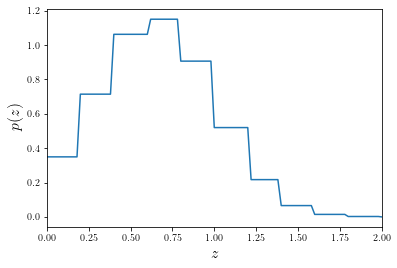

In [9]:
LOC_PRIOR = 0.65
SCALE_PRIOR = 0.35
implicit_prior_norm = qp.Ensemble(qp.stats.norm, data=dict(loc=[[LOC_PRIOR]], scale=[[SCALE_PRIOR]]))
implicit_prior = qp.convert(implicit_prior_norm, 'hist', bins=true_bins)
ax_prior = implicit_prior.plot(xlim=(Z_TRUE_MIN, Z_TRUE_MAX), label=r"unnorm")

# Estimator

Now we try and model the behavior of a simple estimator.
Our simple estimator has a likelihood $p(d | z)$ to return an esimate $d$ for a true value $z$.

In [10]:
# This represents the "estimator" code, we define 10 bins (in true redshift)
# and in each bin the likelihood p(z_obs) is a Gaussian centered on the bin center

N_EST_BINS = N_TRUE_BINS

z_bins = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EST_BINS+1)
z_centers = qp.utils.edge_to_center(z_bins)
z_widths = 0.2 * np.ones(N_EST_BINS)
likelihood = qp.Ensemble(qp.stats.norm, data=dict(loc=np.expand_dims(z_centers, -1), scale=np.expand_dims(z_widths, -1)))

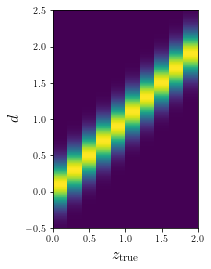

In [11]:
# These are the points at which we evaluate the PDFs
N_OBS_BINS = 300
Z_OBS_MIN, Z_OBS_MAX = -0.5, 2.5
grid_edge = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_BINS+1)
grid_cent = qp.utils.edge_to_center(grid_edge)
p_grid = likelihood.pdf(grid_cent)

plot_kwds = dict(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                 ylim=(Z_OBS_MIN, Z_OBS_MAX), 
                 xlabel=r'$z_{\rm true}$',
                 ylabel=r'$d$')

pl_like = qp.plotting.plot_2d_like(p_grid.T, **plot_kwds)

In [12]:
like_estim = qit.Estimator([z_bins], likelihood)
flat_post = like_estim.flat_posterior(grid_edge)

# Posterior distributions

Ok, now we are going to extract the posterior distributions $p(z|d)$, $p(z|d,\phi^{\dagger})$ and $p(z|d,\phi^{*})$.  In our case these correspond to the posteriors assuming a flat prior, assuming the true distribution as the prior and assuming the implicit prior.

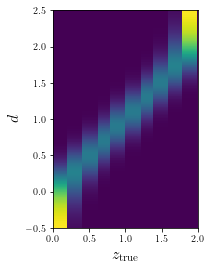

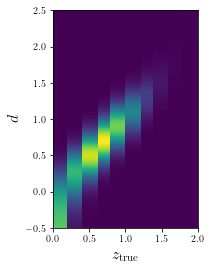

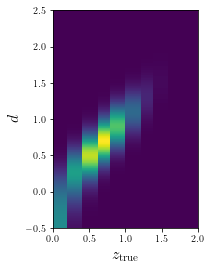

In [13]:
# Let's flip around the likelihood
z_grid = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, 101)
#z_grid = z_centers
#flat_post = qp.Ensemble(qp.stats.hist, data=dict(bins=z_bins, pdfs=p_grid.T))

post_grid = flat_post.get_posterior_grid(z_grid)
est_grid = flat_post.get_posterior_grid(z_grid, implicit_prior)
true_grid = flat_post.get_posterior_grid(z_grid, true_dist)

#post_grid = qp.like_funcs.get_posterior_grid(flat_post, z_grid)
#est_grid = qp.like_funcs.get_posterior_grid(flat_post, z_grid, implicit_prior)
#true_grid = qp.like_funcs.get_posterior_grid(flat_post, z_grid, true_dist)

pl_post = qp.plotting.plot_2d_like(post_grid, **plot_kwds)
pl_est = qp.plotting.plot_2d_like(est_grid, **plot_kwds)
pl_true = qp.plotting.plot_2d_like(true_grid, **plot_kwds)

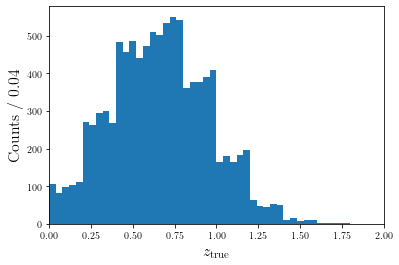

In [14]:
# Now let's sample points in true z
N_SAMPLES = 10000
N_HIST_BINS = 50
z_true_sample = np.squeeze(true_dist.rvs(size=N_SAMPLES))
fig_sample, ax_sample = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel="Counts / %0.2f" % ((Z_TRUE_MAX-Z_TRUE_MIN)/N_HIST_BINS))
hist = ax_sample.hist(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_HIST_BINS+1))

# Sample points from the true distribution

# Create a sample of points in the measured distribution

We do this by sampling a $d$ value from the correct bin for each sampled value in $z_{\rm true}$.

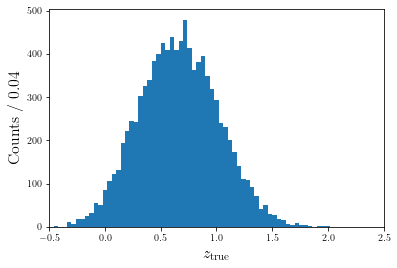

In [15]:
# Now we create a sample of points in measured z.
N_OBS_HIST_BINS = 75
#whichbin = np.searchsorted(z_bins, z_true_sample)-1
#mask = (z_true_sample > 0) * (z_true_sample <= 2.0)
#mask *= (whichbin < z_centers.size)
#whichbin = whichbin[mask]

#sampler = qp.Ensemble(qp.stats.norm, data=dict(loc=np.expand_dims(z_centers[whichbin], -1),
#                                               scale=np.expand_dims(z_widths[whichbin], -1)))
sampler = like_estim.get_sampler(z_true_sample)
mask = (z_true_sample > 0) * (z_true_sample <= 2.0)
z_meas_sample = np.squeeze(sampler.rvs(1))

fig_hmeas, ax_hmeas = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel="Counts / %0.2f" % ((Z_OBS_MAX-Z_OBS_MIN)/N_OBS_HIST_BINS))

hist = ax_hmeas.hist(z_meas_sample, bins=np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_HIST_BINS+1))

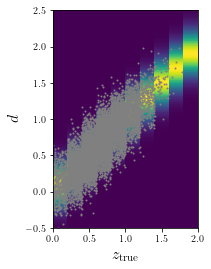

In [16]:
# Overplot the scatter plot on the 2-d likelihood plot
pl_true = qp.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_like2 = pl_true[1]
sc = ax_like2.scatter(z_true_sample[mask], z_meas_sample, s=1, color='gray')

# Profile plot

The previous plot is a bit messy, lets plot the mean and std in slices of x.  (This is a "profile" plot in particle physics jargon.)

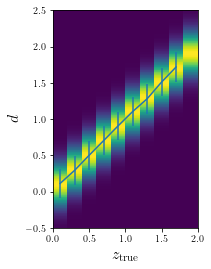

In [17]:
N_PROF_BINS = 10
pl_true2 = qp.plotting.plot_2d_like(p_grid.T, **plot_kwds)
ax_prof = pl_true2[1]
x_prof = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_PROF_BINS+1)
x_prof_cent = qp.utils.edge_to_center(x_prof)
prof_vals, prof_errs = qp.utils.profile(z_true_sample[mask], z_meas_sample, x_prof)
sc = ax_prof.errorbar(x_prof_cent, prof_vals, yerr=prof_errs)

# Posteriors for the measured values

Now we get $p(z|d_{j})$, $p(z | d_{j}, \phi^{\dagger})$ and $p(z | d_{j}, \phi^{*})$ for the samples we simulated.

In [18]:
# Now we get the posteriors for all the measured values
z_meas_bin = np.searchsorted(grid_edge, z_meas_sample)
z_meas_mask = (z_meas_bin >= 0) * (z_meas_bin < grid_cent.size)
z_meas_bin = z_meas_bin[z_meas_mask]

post_ens = like_estim.make_posterior_ensemble(z_grid, z_true_sample)
est_ens = like_estim.make_posterior_ensemble(z_grid, z_true_sample, implicit_prior)
true_ens = like_estim.make_posterior_ensemble(z_grid, z_true_sample, true_dist)

def make_dict(ens, z_grid):
    vals = ens.pdf(z_grid)
    return dict(ens=ens, vals=vals, stack=vals.mean(axis=0))

post_dict_o = qit.like_funcs.make_ensemble_for_posterior_interp(post_grid, z_grid, z_meas_bin)
est_dict_o = qit.like_funcs.make_ensemble_for_posterior_interp(est_grid, z_grid, z_meas_bin)
true_dict_o = qit.like_funcs.make_ensemble_for_posterior_interp(true_grid, z_grid, z_meas_bin)
post_dict_i = make_dict(post_ens, z_grid)
est_dict_i = make_dict(est_ens, z_grid)
true_dict_i = make_dict(true_ens, z_grid)
post_dict = post_dict_i
est_dict = est_dict_i
true_dict = true_dict_i

5 1.0101544615206957


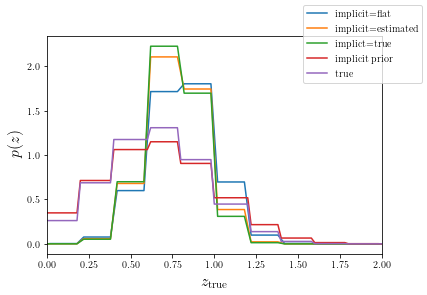

In [19]:
which_sample = np.argmax(z_meas_sample[0:10])
print(which_sample, z_meas_sample[which_sample])
fig_x, ax_x = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                           xlabel=r"$z_{\rm true}$",
                                           ylabel=r"$p(z)$")

ax_x.plot(z_grid, post_dict['vals'][which_sample], label='implicit=flat')
ax_x.plot(z_grid, est_dict['vals'][which_sample], label='implicit=estimated')
ax_x.plot(z_grid, true_dict['vals'][which_sample], label='implict=true')
ax_x.plot(z_grid, np.squeeze(implicit_prior.pdf(z_grid)), label='implicit prior')
ax_x.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label='true')
leg = fig_x.legend()

5 1.0101544615206957


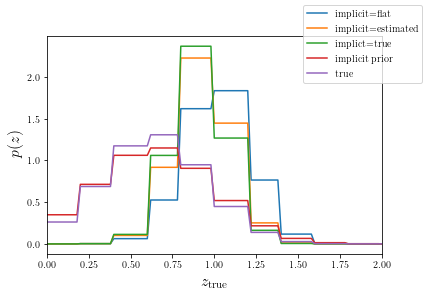

In [20]:
which_sample = np.argmax(z_meas_sample[0:10])
print(which_sample, z_meas_sample[which_sample])
fig_x, ax_x = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                           xlabel=r"$z_{\rm true}$",
                                           ylabel=r"$p(z)$")

ax_x.plot(z_grid, post_dict_o['vals'][which_sample], label='implicit=flat')
ax_x.plot(z_grid, est_dict_o['vals'][which_sample], label='implicit=estimated')
ax_x.plot(z_grid, true_dict_o['vals'][which_sample], label='implict=true')
ax_x.plot(z_grid, np.squeeze(implicit_prior.pdf(z_grid)), label='implicit prior')
ax_x.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label='true')
leg = fig_x.legend()

# Compare the true distribtuion to the naive "stacking"

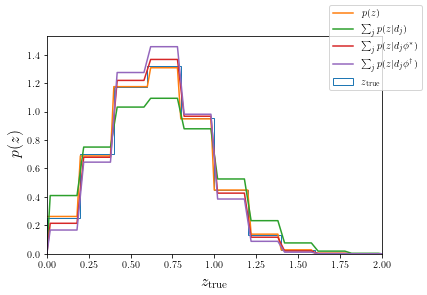

In [21]:
fig_stack, ax_stack = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")
ax_stack.hist(z_true_sample[mask], bins=z_bins, density=True, label=r'$z_{\rm true}$', histtype='step')
ax_stack.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_stack.plot(z_grid, post_dict['stack'], label=r'$\sum_{j} p(z | d_{j})$')
ax_stack.plot(z_grid, est_dict['stack'], label=r'$\sum_{j} p(z | d_{j} \phi^{*})$')
ax_stack.plot(z_grid, true_dict['stack'], label=r'$\sum_{j} p(z | d_{j} \phi^{\dagger})$')
leg = fig_stack.legend()

# Plot some posterior distributions

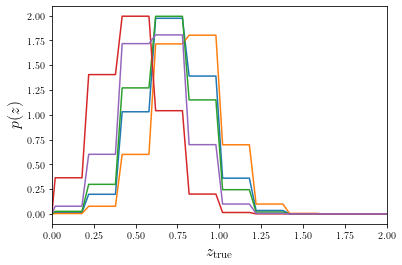

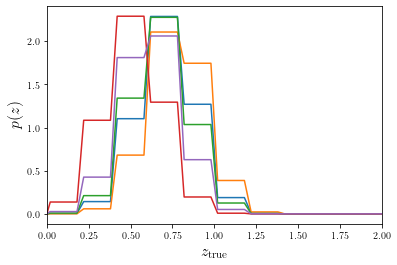

In [22]:
fig_1, ax_1 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")
fig_2, ax_2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                   xlabel=r"$z_{\rm true}$",
                                                   ylabel=r"$p(z)$")

post_vals = post_dict['vals']
est_vals = est_dict['vals']
for i in range(5):
    ax_1.plot(z_grid, post_vals[i])
    ax_2.plot(z_grid, est_vals[i])

# Test the likelihood function by evaluating it for a flat distribution and for the true distribution

In [23]:
N_FIT_BINS = N_TRUE_BINS
model_params = np.ones((1, N_FIT_BINS))
model = qp.Ensemble(qp.stats.hist, data=dict(bins=true_bins, pdfs=model_params))

N_EVAL_PTS = 201
eval_grid = np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_EVAL_PTS)
model_params = np.log(np.ones(N_FIT_BINS))
hist_cents = qp.utils.edge_to_center(z_grid)
true_vals = np.histogram(z_true_sample, bins=np.linspace(Z_TRUE_MIN, Z_TRUE_MAX, N_FIT_BINS+1))[0]
v_flat = qit.like_funcs.log_hyper_like(model_params, est_dict['ens'], model, implicit_prior, eval_grid)
v_true = qit.like_funcs.log_hyper_like(np.log(true_vals), est_dict['ens'], model, implicit_prior, eval_grid)
print(v_flat, v_true)

<ipython-input-23-57cf205e055a>:11: RuntimeWarning: divide by zero encountered in log
  v_true = qit.like_funcs.log_hyper_like(np.log(true_vals), est_dict['ens'], model, implicit_prior, eval_grid)


-87498.72135521776 -92424.02394502706


# Make the objective function for fitting

In this case it is just the log_hyper_like with all of the arguments except for the logs of the bin heights, (i.e. the fitting parameters) specified.

In [24]:
obj_func = qit.like_funcs.make_log_hyper_obj_func(ensemble=est_dict['ens'],\
                   model=model, implicit_prior=implicit_prior, grid=eval_grid)

In [25]:
v_flat = obj_func(model_params)
v_true = obj_func(np.log(true_vals))
print(v_flat, v_true)

<ipython-input-25-70a170767459>:2: RuntimeWarning: divide by zero encountered in log
  v_true = obj_func(np.log(true_vals))


-87498.72135521776 -92424.02394502706


In [26]:
model_params

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Fit for the hyper-parameters

In [27]:
result = minimize(obj_func, model_params)

In [28]:
# Check the current value of the objective function
obj_func(result['x'])

-92702.80999381498

In [29]:
# Extract the parameters and convert back to counts (The Jacobian happens to be identical to the fitted values)
fitted_vals = np.exp(result['x'])
fitted_errs = np.sqrt(np.array([result['hess_inv'][i,i] for i in range(N_FIT_BINS)]))
norm_factor = 2 / fitted_vals.sum()
normed_fit = norm_factor * fitted_vals
jac = fitted_vals
# Convert to PDF, for plotting
normed_errs = norm_factor * jac * fitted_errs
model.update_objdata(dict(pdfs=np.expand_dims(normed_fit, 0)))
model_vals = np.squeeze(model.pdf(z_grid))

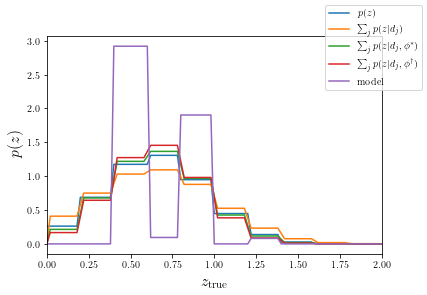

In [30]:
fig_result, ax_result = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                     xlabel=r"$z_{\rm true}$",
                                                     ylabel=r"$p(z)$")
ax_result.set_xlim(Z_TRUE_MIN, Z_TRUE_MAX)
ax_result.set_ylabel(r'$p(z)$')
ax_result.set_xlabel(r'$z_{\rm true}$')
ax_result.plot(z_grid, np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_result.plot(z_grid, post_dict['stack'], label=r'$\sum_j p(z | d_{j}$)')
ax_result.plot(z_grid, est_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{*})$')
ax_result.plot(z_grid, true_dict['stack'], label=r'$\sum_j p(z | d_{j}, \phi^{\dagger})$')
#ax_result.errorbar(hist_cents, normed_fit, yerr=normed_errs, label="result")
ax_result.plot(z_grid, model_vals, label='model')
leg = fig_result.legend()


# Fitting in counts space

In [31]:
N_LIKE_PTS = 301
N_OBS_BINS = 15
like_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_LIKE_PTS)
eval_bins = np.searchsorted(z_bins, eval_grid, side='left')
eval_mask = (eval_bins >= 0) * (eval_bins < z_bins.size-1)
eval_grid = eval_grid[eval_mask]
eval_bins = eval_bins[eval_mask]
like_eval = likelihood.pdf(like_grid)[eval_bins]
obs_cts_grid = np.linspace(Z_OBS_MIN, Z_OBS_MAX, N_OBS_BINS+1)
data_cts = np.histogram(z_meas_sample, bins=obs_cts_grid)[0]

obj_func_binned = qp.like_funcs.make_binnned_loglike_obj_func(model=model, data_cts=data_cts,\
                          like_eval=like_eval, like_grid=like_grid, model_grid=eval_grid, cts_grid=obs_cts_grid)

In [32]:
flat = 0.5*data_cts.sum()*np.ones(N_FIT_BINS)
model_flat = qp.like_funcs.model_counts(np.log(flat), model, like_eval, like_grid, eval_grid, obs_cts_grid)
model_true = qp.like_funcs.model_counts(np.log(true_vals), model, like_eval, like_grid, eval_grid, obs_cts_grid)
ll_flat = obj_func_binned(np.log(flat))
ll_true = obj_func_binned(np.log(true_vals))
print(ll_flat, ll_true)

-33933.69381742371 -60615.736651781175


<ipython-input-32-9093367b3467>:3: RuntimeWarning: divide by zero encountered in log
  model_true = qp.like_funcs.model_counts(np.log(true_vals), model, like_eval, like_grid, eval_grid, obs_cts_grid)
<ipython-input-32-9093367b3467>:5: RuntimeWarning: divide by zero encountered in log
  ll_true = obj_func_binned(np.log(true_vals))


In [33]:
result = minimize(obj_func_binned, np.ones(N_FIT_BINS))

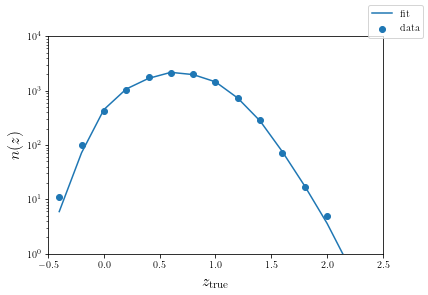

In [35]:
model_cts = qit.like_funcs.model_counts(result['x'], model, like_eval, like_grid, eval_grid, obs_cts_grid)
cts_cent = 0.5 * (obs_cts_grid[1:] + obs_cts_grid[:-1])
fig_fit, ax_fit = qp.plotting.make_figure_axes(xlim=(Z_OBS_MIN, Z_OBS_MAX),
                                               xlabel=r'$z_{\rm true}$',
                                               ylabel=r'$n(z)$')
ax_fit.set_yscale('log')
ax_fit.set_ylim(1., 1e4)
ax_fit.scatter(cts_cent, data_cts, label='data')
ax_fit.plot(cts_cent, model_cts, label='fit')
leg = fig_fit.legend()

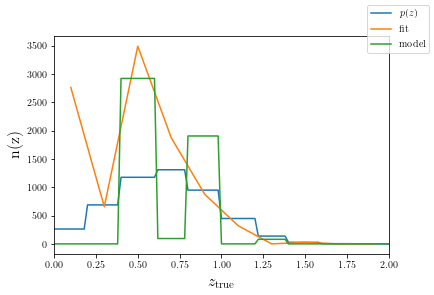

In [36]:
fit_cts = np.exp(result['x'])
true_cents = qp.utils.edge_to_center(true_bins)
pdf_true = true_vals * 2 / true_vals.sum()
fig_fit2, ax_fit2 = qp.plotting.make_figure_axes(xlim=(Z_TRUE_MIN, Z_TRUE_MAX),
                                                xlabel=r'$z_{\rm true}$',
                                                ylabel=r'n(z)')
ax_fit2.plot(z_grid, 0.1*data_cts.sum()*np.squeeze(true_dist.pdf(z_grid)), label=r'$p(z)$')
ax_fit2.plot(true_cents, fit_cts, label="fit")
ax_fit2.plot(z_grid, 0.1*data_cts.sum()*model_vals, label='model')
leg = fig_fit2.legend()


In [37]:
data_cts.sum()

9998